In [1]:
import os.path as osp, os
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch, numpy as np, polars as pl
from data.graphdataset import ThermoMLDataset, ramirez, ThermoMLpara
from train.train import create_model
from train.models import PNAPCSAFT
from train.model_deg import calc_deg
from data.graph import from_InChI
from train.parametrisation import MAPE, rhovp_data
import matplotlib.pyplot as plt
from configs.default import get_config
import pickle, numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

torch.cuda.is_available()

False

In [2]:
ra_loader = ramirez("./data/ramirez2022")
ra_para = {}
for graph in ra_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    ra_para[inchi] = para.tolist()[0]
tml_loader = ThermoMLpara("./data/thermoml")
tml_para = {}
for graph in tml_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    tml_para[inchi] = para.tolist()[0]
path = osp.join("data", "thermoml")
testloader = ThermoMLDataset(path)
device = torch.device("cpu")

In [3]:
config = get_config()
config.propagation_depth=4
config.hidden_dim=128
config.num_mlp_layers=2
config.pre_layers=1
config.post_layers=3

In [4]:
model_dtype = torch.float64
# Create and initialize the network.
deg_model2 = calc_deg("thermoml", './')
model2 = create_model(config, deg_model2).to(device, model_dtype)
# Create and initialize the network.
deg_model1 = calc_deg("ramirez", './')
model1 = create_model(config, deg_model1).to(device, model_dtype)
# Set up checkpointing of the model.
def loadckp(ckp_path: str, model: PNAPCSAFT):
    if osp.exists(ckp_path):
        checkpoint = torch.load(ckp_path, map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"model checkpoint step {checkpoint['step']}")
        del checkpoint
        
ckp_path = "./train/checkpoints/model2-13_62e6.pth"
loadckp(ckp_path, model2)
ckp_path = "./train/checkpoints/model3-2_80e6.pth"
loadckp(ckp_path, model1)

model checkpoint step 13630000
model checkpoint step 2800000


In [ ]:
def model_para_fn(model: PNAPCSAFT):
    model_para = {}
    model_array = {}
    model.eval()
    with torch.no_grad():
        for graphs in testloader:
            graphs.x = graphs.x.to(model_dtype)
            graphs.edge_attr = graphs.edge_attr.to(model_dtype)
            graphs.edge_index = graphs.edge_index.to(torch.int64)

            graphs = graphs.to(device)
            parameters = model(graphs)
            params = parameters.squeeze().to(torch.float64).numpy()
            rho = graphs.rho.view(-1, 5).to(torch.float64).numpy()
            vp = graphs.vp.view(-1, 5).to(torch.float64).numpy()
            mden_array, mvp_array = MAPE(params, rho, vp, False)
            mden, mvp = mden_array.mean(), mvp_array.mean()
            parameters = parameters.tolist()[0]
            model_para[graphs.InChI] = (parameters, mden, mvp)
            model_array[graphs.InChI] = (mden_array, mvp_array)
    return model_para, model_array

model1_para, model1_array = model_para_fn(model1)
model2_para, model2_array = model_para_fn(model2)

In [ ]:
def datacsv(model_para):
    data = {"inchis":[],"mden":[],"mvp":[]}
    for inchi in model_para:
        data['inchis'].append(inchi)
        data['mden'].append(model_para[inchi][1])
        data['mvp'].append(model_para[inchi][2])
    return data

data2 = datacsv(model2_para)
data1 = datacsv(model1_para)
model1data = pl.DataFrame(data1)
model2data = pl.DataFrame(data2)
model1data.write_csv('model1.csv')
model2data.write_csv('model2.csv')

In [ ]:
with open("./data/thermoml/raw/para3_fitted.pkl", "rb") as file:
        # A new file will be created
        para_fitted = pickle.load( file)

In [ ]:
inchi = "InChI=1S/C8H15N2.BF4/c1-3-4-5-10-7-6-9(2)8-10;2-1(3,4)5/h6-8H,3-5H2,1-2H3;/q+1;-1"
def compare_model(model_para, model_array):
    ml, mden, mvp = model_para[inchi]
    mden_array, mvp_array = model_array[inchi]
    if inchi in ra_para:
        ra = ra_para[inchi]
    else:
        ra = [0, 0, 0]
    if inchi in para_fitted:
        fit, mden_fit, mvp_fit = para_fitted[inchi]
    else:
        fit, mden_fit, mvp_fit = [0,0,0],0,0
    print("#### (ra, ml, fit) ####")
    for row in zip(ra, ml, fit):
        print(row)
    print("#### mden, mvp ####")
    print(mden, mvp)
    print(mden_fit, mvp_fit)

compare_model(model2_para, model2_array)
compare_model(model1_para, model1_array)

In [ ]:
with torch.no_grad(): 
    graphs = from_InChI(inchi, with_hydrogen=True)
    graphs.x = graphs.x.to(model_dtype)
    graphs.edge_attr = graphs.edge_attr.to(model_dtype)
    graphs.edge_index = graphs.edge_index.to(torch.int64)

    graphs = graphs.to(device)
    parameters = model2(graphs)
    params = parameters.squeeze().to(torch.float64).detach().numpy()
params

In [5]:
def plotdata(inchi: str, molecule_name: str, models: list[PNAPCSAFT]):
    def pltline(x, y):
        return plt.plot(x, y, linewidth=0.5)

    def pltscatter(x, y):
        return plt.scatter(x, y, marker="x", c="black", s=10)

    def plterr(x, y, m):
        tb = 0
        for i, mape in enumerate(np.round(m, decimals=1)):
            ta = x[i]
            if (mape > 1) & (ta - tb > 2):
                tb = ta
                plt.text(x[i], y[i], f"{mape} %", ha="center", va="center", fontsize=8)

    
    with torch.no_grad():
        for graphs in testloader:
            if inchi == graphs.InChI:
                break
        graphs.x = graphs.x.to(model_dtype)
        graphs.edge_attr = graphs.edge_attr.to(model_dtype)
        graphs.edge_index = graphs.edge_index.to(torch.int64)
        graphs = graphs.to(device)
        list_params = []
        for model in models:
            model.eval()
            parameters = model(graphs)
            params = parameters.squeeze().to(torch.float64).numpy()
            list_params.append(params)

    rho = graphs.rho.view(-1, 5).to(torch.float64).numpy()
    vp = graphs.vp.view(-1, 5).to(torch.float64).numpy()
    pred_den_list, pred_vp_list  = [], []
    for params in list_params:
        pred_den, pred_vp = rhovp_data(params, rho, vp)
        pred_den_list.append(pred_den)
        pred_vp_list.append(pred_vp)
    if inchi in ra_para:
        params = np.asarray(ra_para[inchi])
        ra_den, ra_vp = rhovp_data(params, rho, vp)

    if ~np.all(vp == np.zeros_like(vp)):
        idx = np.argsort(vp[:, 0], 0)
        x = vp[idx, 0]
        y = vp[idx, -1] / 100000
        pltscatter(x, y)

        for pred_vp in pred_vp_list:    
            y = pred_vp[idx] / 100000
            pltline(x, y)
            mvp_model = 100 * np.abs(vp[idx, -1] - pred_vp[idx]) / vp[idx, -1]
            #plterr(x, y, mvp_model)

        if inchi in ra_para:
            ra_vp = ra_vp
            y = ra_vp[idx] / 100000
            pltline(x, y)
            mvp_ra = 100 * np.abs(vp[idx, -1] - ra_vp[idx]) / vp[idx, -1]
            #plterr(x, y * 1.01, mvp_ra)

        # Customize the plot appearance
        pltcustom(inchi in ra_para, "log", "Pressão de vapor (bar)")

        # Save the plot as a high-quality image file
        path = osp.join("images", "vp_" + molecule_name + ".png")
        plt.savefig(path, dpi=300, format="png", bbox_inches="tight", transparent=True)
        plt.show()

    if ~np.all(rho == np.zeros_like(rho)):
        idx_p = abs(rho[:, 1] - 101325) < 15_000
        rho = rho[idx_p]
        idx = np.argsort(rho[:, 0], 0)
        x = rho[idx, 0]
        y = rho[idx, -1]
        pltscatter(x, y)

        for pred_den in pred_den_list:
            pred_den = pred_den[idx_p]
            y = pred_den[idx]
            pltline(x, y)
            mden_model = 100 * np.abs(rho[idx, -1] - pred_den[idx]) / rho[idx, -1]
            #plterr(x, y, mden_model)    

        if inchi in ra_para:
            ra_den = ra_den[idx_p]
            y = ra_den[idx]
            pltline(x, y)
            mden_ra = 100 * np.abs(rho[idx, -1] - ra_den[idx]) / rho[idx, -1]
            #plterr(x, y, mden_ra)

        # Customize the plot appearance
        pltcustom(inchi in ra_para, "linear", "Densidade (mol / m³)")
        path = osp.join(
            "images", "den_" + molecule_name + ".png"
        )
        plt.savefig(path, dpi=300, format="png", bbox_inches="tight", transparent=True)
        plt.show()


def pltcustom(ra, scale="linear", ylabel=""):
    plt.xlabel("T (K)")
    plt.ylabel(ylabel)
    plt.title("")
    legend = [
        "Pontos experimentais",
        "Modelo 1",
        "Modelo 2"
    ]
    if ra:
        legend += [f"Ramírez-Vélez et al. (2022)"]
    plt.legend(legend, loc = (1.01,0.75))
    plt.grid(False)
    plt.yscale(scale)

In [21]:
inchi = "InChI=1S/C10H16/c1-2-9-7-4-5-8(6-7)10(9)3-1/h7-10H,1-6H2/t7-,8+,9+,10-"

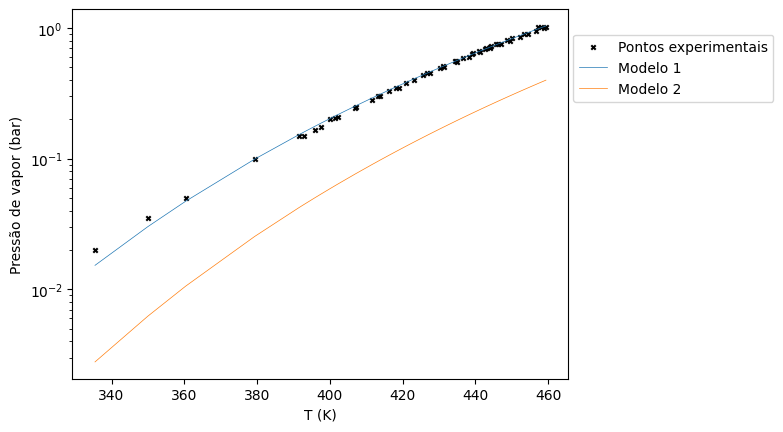

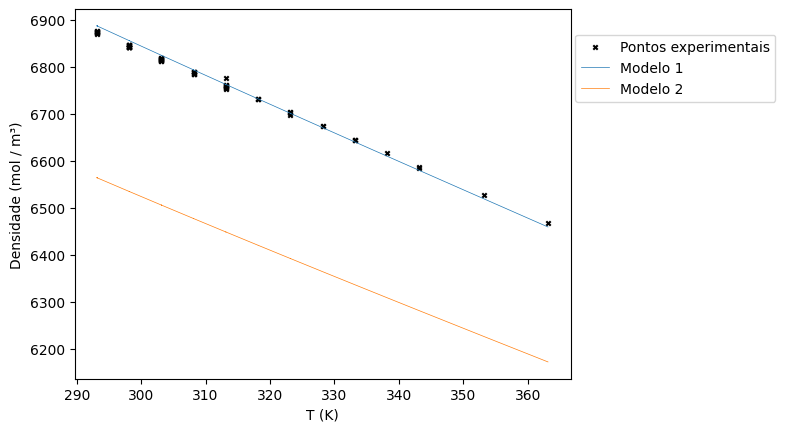

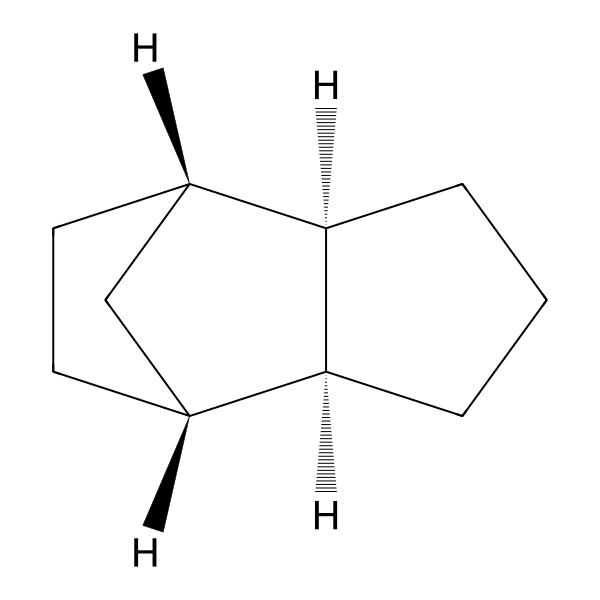

In [22]:
molecule_name = 'UNKNOWN'
plotdata(inchi, molecule_name, [model1, model2])
mol = Chem.MolFromInchi(inchi)
img = Draw.MolToImage(mol, size=(600,600))
img.show()